# TV regularization

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import pylops

from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import SplitBregman as SplitBregman_f

In this notebook we will use the *Split Bregman* solver to solve the following unconstrained least-squares problem with multiple L1 constraints:

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||\Phi_i(\textbf{x}) |||_1$$

More specifically we will limit ourselves to the case of $\Phi_i$ being linear

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||\Phi_i \textbf{x} |||_1$$

Such a problem is first casted as an equivalent constrained least-squares problem

$$ J =  \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 + \sum_i ||d_i|||_1  \quad subj.to \quad \Phi_i \textbf{x} = d_i$$

and then solved as an augmented unconstrained equivalent

$$ J = \sum_i ||d_i||_1 + \sum_i \lambda_i/2 ||d_i -  \Phi_i \textbf{x}|||_2 + \mu/2 ||\textbf{b} - \textbf{Ax} |||_2 $$

## Denoising

### 1D

$$ J =  \mu/2 ||\textbf{y} - \textbf{x} |||_2 +  ||\nabla \textbf{x}|||_1$$

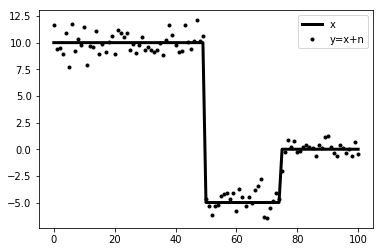

In [2]:
np.random.seed(1)

nx = 101
x = np.zeros(nx)
x[:nx//2] = 10
x[nx//2:3*nx//4] = -5

Dop = FirstDerivative(nx, edge=True)
D2op = SecondDerivative(nx, edge=True)
Iop = Identity(nx)

n = np.random.normal(0, 1, nx)
y = Iop*(x + n)
ymask = y.copy()
#y = Rop*(x + n)
#ymask = Rop.mask(x) + n

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, '.k', label='y=x+n')
plt.legend()

In [3]:
def shrinkage(x, thresh):
    xabs = np.abs(x)
    return x/(xabs+1e-10) * np.maximum(xabs - thresh, 0)

def SplitBregman(y, Op, Dop, mu, lamda, niter, niterinner, tol=1e-3, tau=1., **kwargs_ls):
    nregs = len(Dop)
    b = [np.zeros(Op.shape[0])]*nregs
    d = [np.zeros(Op.shape[0])]*nregs
    xinv = np.zeros_like(np.zeros(Op.shape[1]))
    xold = np.inf * np.ones_like(np.zeros(Op.shape[1]))
    
    iiter = 0
    while np.linalg.norm(xinv - xold) > tol:
        xold = xinv
        iiter += 1
        for iiterinn in range(niterinner):
            # setup regularized problem
            xinv = RegularizedInversion(Op, Dop, y, dataregs=[d[ireg]-b[ireg] for ireg in range(nregs)], 
                                        epsRs=[np.sqrt(lamda[ireg]/2)/np.sqrt(mu/2) for ireg in range(nregs)],
                                        **kwargs_ls)
            #plt.figure()
            #plt.plot(xinv)
            #plt.figure()
            #plt.plot(Dop*xinv+b)
            d = [shrinkage(Dop[ireg]*xinv+b[ireg], lamda[ireg]) for ireg in range(nregs)]
            #plt.figure()
            #plt.plot(d)
            
        b = [b[ireg]+ tau*(Dop[ireg]*xinv - d[ireg]) for ireg in range(nregs)]
        if iiter > niter:
            break
    return xinv, iiter-1

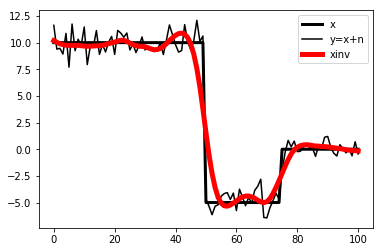

In [4]:
lamda = 1e2
xinv = RegularizedInversion(Iop, [D2op], y, epsRs=[np.sqrt(lamda/2)],
                            **dict(iter_lim=30))

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, 'k', label='y=x+n')
plt.plot(xinv, 'r', lw=5, label='xinv')
plt.legend()

55


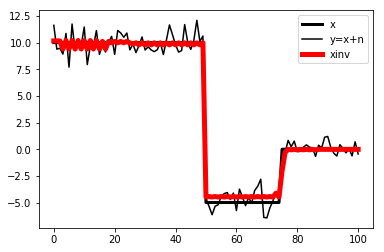

In [5]:
mu = 0.01
lamda = 0.2
niter = 100
niterinner = 3

xinv, niter = SplitBregman(y, Iop, [Dop], mu, [lamda], niter, niterinner, tol=1e-4, tau=1.,
                           **dict(iter_lim=30, damp=1e-10))
print(niter)

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, 'k', label='y=x+n')
plt.plot(xinv, 'r', lw=5, label='xinv')
plt.legend();

55


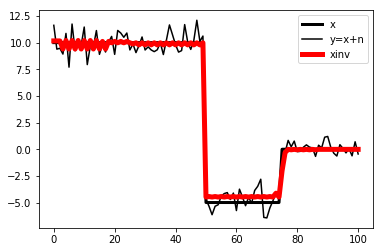

In [6]:
xinv_f, niter_f = SplitBregman_f(Iop, [Dop], y, niter, niterinner, mu=mu, epsRL1s=[lamda], 
                                 tol=1e-4, tau=1, **dict(iter_lim=30, damp=1e-3))
print(niter)

plt.figure()
plt.plot(x, 'k', lw=3, label='x')
plt.plot(ymask, 'k', label='y=x+n')
plt.plot(xinv_f, 'r', lw=5, label='xinv')
plt.legend();

### 2D

$$ J =  \mu/2 ||\textbf{y} - \textbf{x} |||_2 +  ||\nabla_x \textbf{x}|||_1  +  ||\nabla_y \textbf{x}|||_1$$

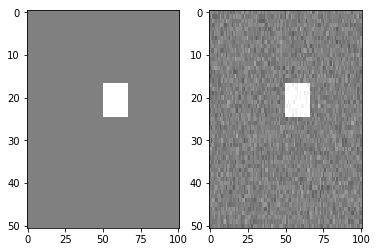

In [7]:
ny, nx = 51, 101
x = np.zeros((ny, nx))
x[ny//3:ny//2, nx//2:2*nx//3] = 1

Iop = Identity(ny*nx)
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True)]
D2op = Laplacian(dims=(ny, nx), edge=True)

n = np.random.normal(0, 0.1, (ny, nx))
y = Iop*(x.flatten() + n.flatten())
y = y.reshape(ny, nx)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(y, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight');

55


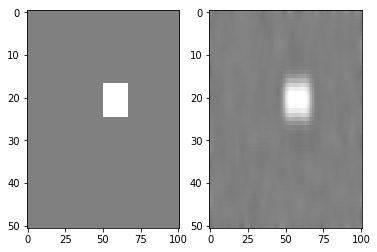

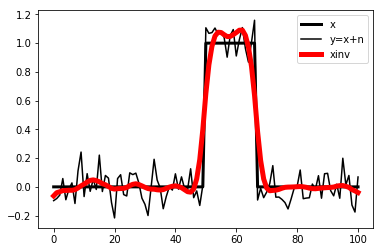

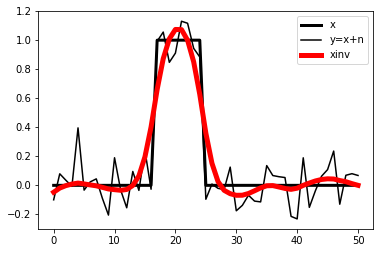

In [8]:
lamda = 1e1
xinv_sm = RegularizedInversion(Iop, [D2op], y.flatten(), epsRs=[np.sqrt(lamda/2)],
                            **dict(iter_lim=30))
xinv_sm = xinv_sm.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_sm[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_sm[:, 60], 'r', lw=5, label='xinv')
plt.legend();

40


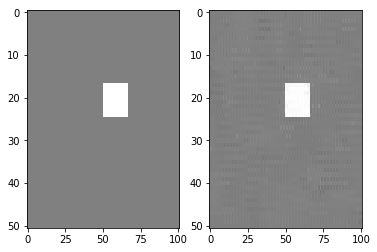

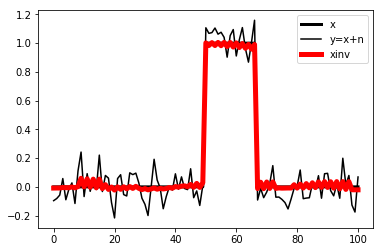

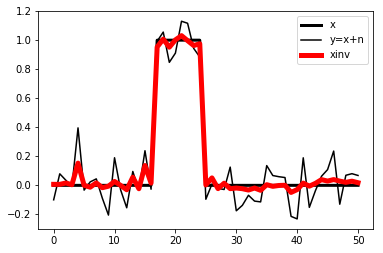

In [9]:
mu = 1.4
lamda = [0.3, 0.5]
niter = 40
niterinner = 1

xinv, niter = SplitBregman(y.flatten(), Iop, Dop, mu, lamda, niter, niterinner, tol=1e-6, tau=1.,
                           **dict(iter_lim=30, damp=1e-10))
xinv = xinv.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv')
plt.legend();

And with the smooth solution as initial guess

20


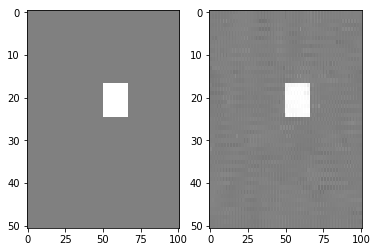

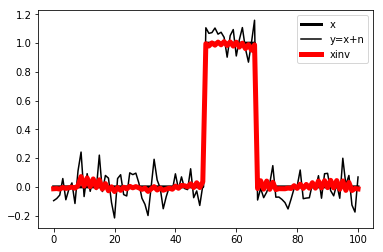

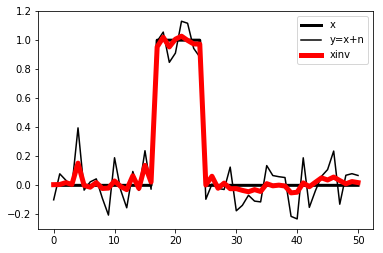

In [10]:
mu = 1.4
lamda = [0.3, 0.5]
niter = 20
niterinner = 1

xinv_f, niter_f = SplitBregman_f(Iop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda, 
                                 tol=1e-4, tau=1., x0=xinv_sm.flatten(), **dict(iter_lim=30, damp=1e-10))
xinv_f = xinv_f.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_f, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_f[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_f[:, 60], 'r', lw=5, label='xinv')
plt.legend();

Finally blocky in one direction and smooth in the other

50


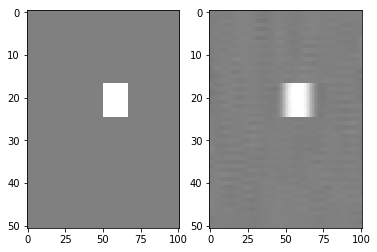

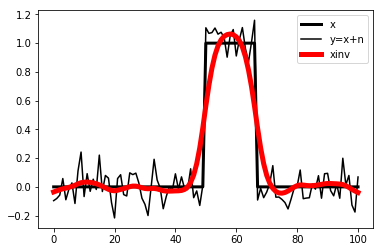

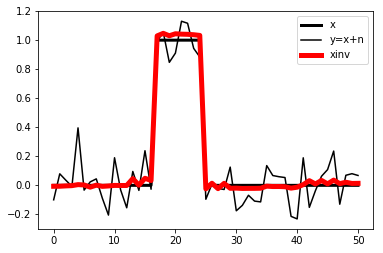

In [11]:
mu = 1.4
lamda = [0.3, 0.5]
niter = 50
niterinner = 1

Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True),
       SecondDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True)]

xinv_f, niter_f = SplitBregman_f(Iop, [Dop[0]], y.flatten(), niter, niterinner, mu=mu, epsRL1s=[lamda[0]],
                                 RegsL2=[Dop[1]], epsRL2s=[100*lamda[1]], tol=1e-4, tau=1., 
                                 x0=xinv_sm.flatten(), **dict(iter_lim=30, damp=1e-2))
xinv_f = xinv_f.reshape(ny, nx)
print(niter)

fig, axs = plt.subplots(1, 2)
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_f, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(y[20], 'k', label='y=x+n')
plt.plot(xinv_f[20], 'r', lw=5, label='xinv')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(y[:, 60], 'k', label='y=x+n')
plt.plot(xinv_f[:, 60], 'r', lw=5, label='xinv')
plt.legend();

## MRI imaging

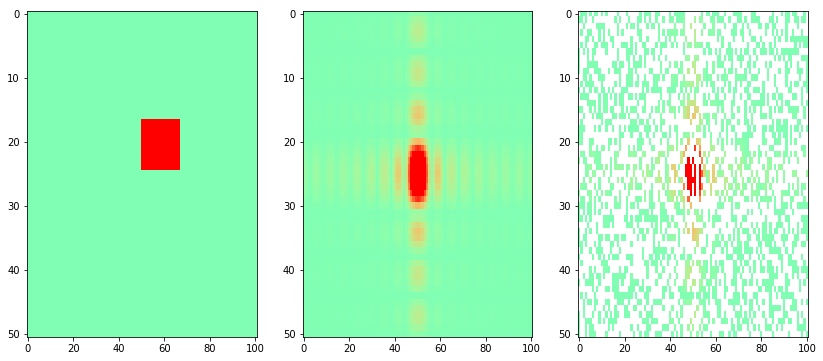

In [12]:
np.random.seed(1)

ny, nx = 51, 101
x = np.zeros((ny, nx))
x[ny//3:ny//2, nx//2:2*nx//3] = 1

perc_subsampling=0.4
nxsub=int(np.round(ny*nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny*nx))[:nxsub])
Rop = Restriction(ny*nx, iava, dtype=np.complex)
Fop = FFT2D(dims=(ny, nx))

n = np.random.normal(0, 0.0, (ny, nx))
y = Rop*(Fop*x.flatten() + n.flatten())
yfft = Fop*x.flatten() + n.flatten()
yfft = np.fft.fftshift(yfft.reshape(ny,nx))

ymask = Rop.mask(Fop*(x.flatten()) + n.flatten())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=-1, vmax=1, cmap='rainbow')
axs[0].axis('tight')
axs[1].imshow(np.abs(yfft), vmin=-1, vmax=1, cmap='rainbow')
axs[1].axis('tight');
axs[2].imshow(np.abs(ymask), vmin=-1, vmax=1, cmap='rainbow')
axs[2].axis('tight');

Regularized LS and sparse with anisotropic TV regularization

Split-Bregman optimization
----------------------------------------------------------
The Operator Op has 2060 rows and 5151 cols
niter_outer =  20      niter_inner =  10
mu = 1.50e+00          epsL1 = [0.3, 0.3]     tol = 1.00e-04
-----------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -5.83801e-02        1.359e-01        2.113e+02
     2  -5.04839e-02        3.598e-01        1.550e+02
     3  -3.20266e-02        3.386e-01        6.484e+01
     4  -3.19273e-02        3.132e-01        6.301e+01
     5  -3.25059e-02        2.951e-01        6.113e+01
     6  -3.26991e-02        2.796e-01        5.994e+01
     7  -3.28156e-02        2.662e-01        5.896e+01
     8  -3.28969e-02        2.545e-01        5.811e+01
     9  -3.29545e-02        2.442e-01        5.737e+01
    10  -3.29955e-02        2.352e-01        5.672e+01
    11  -3.30242e-02        2.272e-01        5.614e+01
    12  -3.30428e-02        2.201e-01        5.

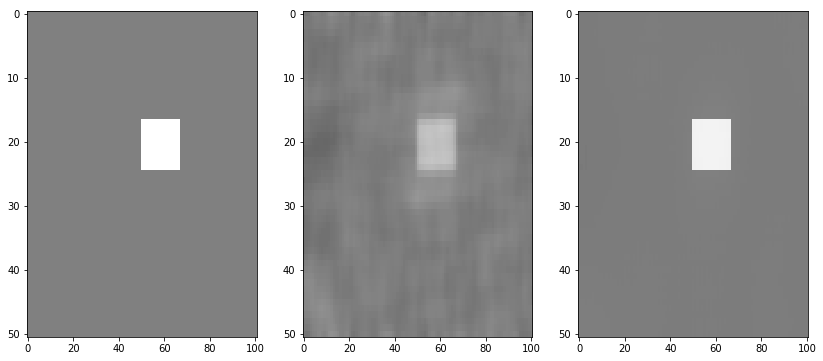

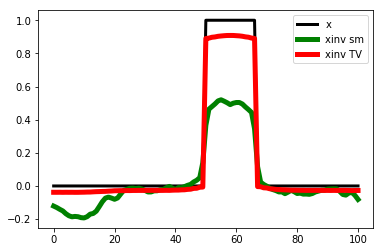

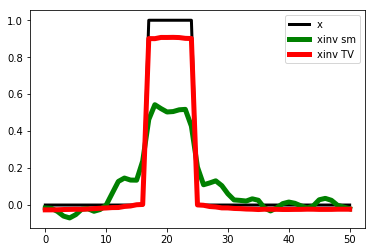

In [13]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True, dtype=np.complex),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True, dtype=np.complex)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.complex)


# L2
xinv_sm = RegularizedInversion(Rop*Fop, [D2op], y.flatten(), epsRs=[5e-1],
                               **dict(iter_lim=30))
xinv_sm = np.real(xinv_sm.reshape(ny, nx))

# TV
mu = 1.5
lamda = [0.3, 0.3]
niter = 20
niterinner = 10

xinv, niter = SplitBregman_f(Rop*Fop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda,
                             tol=1e-4, tau=1., show=True, **dict(iter_lim=30, damp=1e-5))
xinv = np.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=-1, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();

Similar but with isotropic TV regularization

Split-Bregman optimization
----------------------------------------------------------
The Operator Op has 2060 rows and 5151 cols
niter_outer =  20      niter_inner =  10
mu = 1.50e+00          epsL1 = [0.1]     tol = 1.00e-04
-----------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -2.39404e-02        5.698e-03        1.094e+02
     2  -2.44579e-02        5.601e-03        5.112e+01
     3  -2.41655e-02        5.284e-03        5.007e+01
     4  -2.51438e-02        5.110e-03        4.940e+01
     5  -2.55030e-02        4.976e-03        4.914e+01
     6  -2.57424e-02        4.856e-03        4.899e+01
     7  -2.61269e-02        4.746e-03        4.888e+01
     8  -2.65805e-02        4.644e-03        4.879e+01
     9  -2.68846e-02        4.550e-03        4.872e+01
    10  -2.68962e-02        4.463e-03        4.868e+01
    11  -2.66734e-02        4.382e-03        4.864e+01
    12  -2.64496e-02        4.308e-03        4.860e+

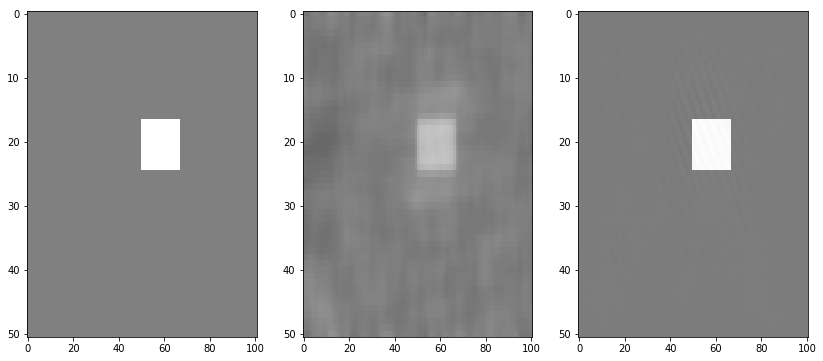

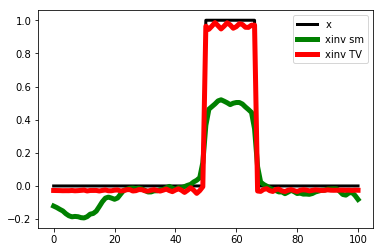

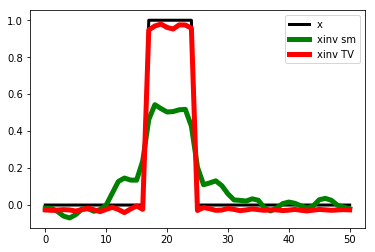

In [14]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=False, dtype=np.complex) + 
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=False, dtype=np.complex)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.complex)

# TV
mu = 1.5
lamda = [0.1]
niter = 20
niterinner = 10

xinv, niter = SplitBregman_f(Rop*Fop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda,
                             tol=1e-4, tau=1., show=True, **dict(iter_lim=30, damp=1e-5))
xinv = np.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=-1, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=-1, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=-1, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();

We do the same with the Shepp Logan phantom

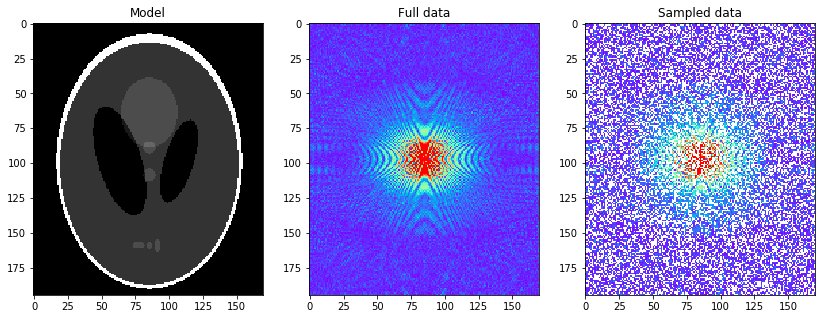

In [19]:
np.random.seed(1)

x = np.load('../data/optimization/shepp_logan_phantom.npy')
x = x/x.max()
ny, nx = x.shape

perc_subsampling=0.6
nxsub=int(np.round(ny*nx*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(ny*nx))[:nxsub])
Rop = pylops.Restriction(ny*nx, iava, dtype=np.complex)
Fop = pylops.signalprocessing.FFT2D(dims=(ny, nx))

n = np.random.normal(0, 0.0, (ny, nx))
y = Rop*(Fop*x.flatten() + n.flatten())
yfft = Fop*x.flatten() + n.flatten()

yfft = np.fft.fftshift(yfft.reshape(ny,nx))

ymask = Rop.mask(Fop*(x.flatten()) + n.flatten())
ymask = ymask.reshape(ny, nx)
ymask.data[:] = np.fft.fftshift(ymask.data)
ymask.mask[:] = np.fft.fftshift(ymask.mask)

fig, axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].set_title('Model')
axs[0].axis('tight')
axs[1].imshow(np.abs(yfft), vmin=0, vmax=1, cmap='rainbow')
axs[1].set_title('Full data')
axs[1].axis('tight')
axs[2].imshow(np.abs(ymask), vmin=0, vmax=1, cmap='rainbow')
axs[2].set_title('Sampled data')
axs[2].axis('tight');

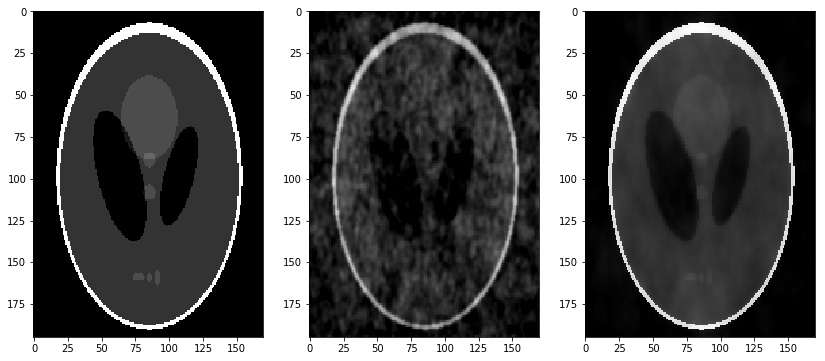

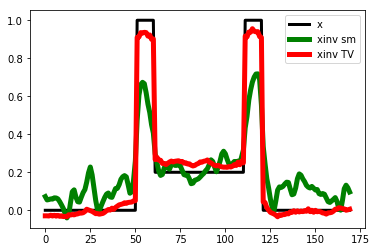

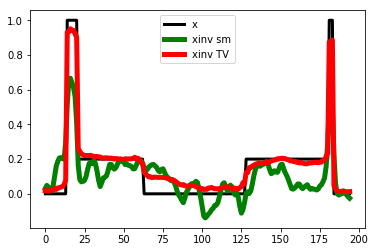

In [16]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=True, dtype=np.complex),
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=True, dtype=np.complex)]
D2op = Laplacian(dims=(ny, nx), edge=True, dtype=np.complex)

# L2
xinv_sm = RegularizedInversion(Rop*Fop, [D2op], y.flatten(), epsRs=[5e-1],
                               **dict(iter_lim=30))
xinv_sm = np.real(xinv_sm.reshape(ny, nx))

# TV
mu = 1.5
lamda = [0.3, 0.3]
niter = 5
niterinner = 10

xinv, niter = SplitBregman_f(Rop * Fop, Dop, y.flatten(), niter, niterinner,
                             mu=mu, epsRL1s=lamda, tol=1e-4, tau=1., show=False,
                             **dict(iter_lim=20, damp=1e-2))
xinv = np.real(xinv.reshape(ny, nx))
fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[20], 'k', lw=3, label='x')
plt.plot(xinv_sm[20], 'g', lw=5, label='xinv sm')
plt.plot(xinv[20], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, 60], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, 60], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, 60], 'r', lw=5, label='xinv TV')
plt.legend();

Split-Bregman optimization
----------------------------------------------------------
The Operator Op has 19890 rows and 33150 cols
niter_outer =  20      niter_inner =  10
mu = 1.50e+00          epsL1 = [0.8]     tol = 1.00e-04
-----------------------------------------------------------

   Itn          x[0]           r2norm          r12norm
     1  -1.86144e-01        2.867e+01        1.612e+03
     2  -1.63366e-01        7.030e+01        1.269e+03
     3  -1.48306e-01        1.058e+02        1.090e+03
     4  -1.30666e-01        1.303e+02        9.726e+02
     5  -1.27463e-01        1.462e+02        8.914e+02
     6  -1.24369e-01        1.556e+02        8.307e+02
     7  -1.26040e-01        1.609e+02        7.874e+02
     8  -1.26235e-01        1.642e+02        7.556e+02
     9  -1.25483e-01        1.664e+02        7.300e+02
    10  -1.26724e-01        1.677e+02        7.101e+02
    11  -1.32447e-01        1.685e+02        6.944e+02
    12  -1.36042e-01        1.692e+02        6.817

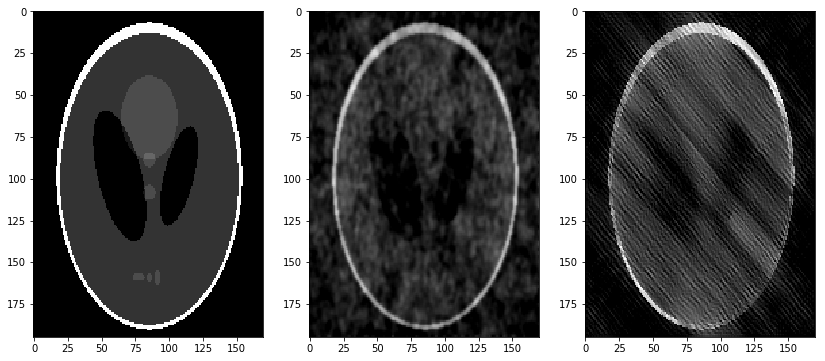

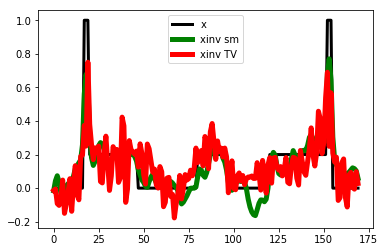

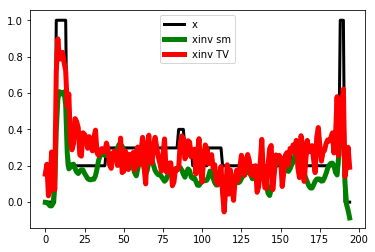

In [22]:
Dop = [FirstDerivative(ny*nx, dims=(ny, nx), dir=0, edge=False, dtype=np.complex) + \
       FirstDerivative(ny*nx, dims=(ny, nx), dir=1, edge=False, dtype=np.complex)]

# TV
mu = 1.5
lamda = [0.8]
niter = 20
niterinner = 10

xinv, niter = SplitBregman_f(Rop*Fop, Dop, y.flatten(), niter, niterinner, mu=mu, epsRL1s=lamda,
                             tol=1e-4, tau=1., show=True, **dict(iter_lim=5, damp=1e-2))
xinv = np.real(xinv.reshape(ny, nx))

fig, axs = plt.subplots(1, 3, figsize=(14, 6))
axs[0].imshow(x, vmin=0, vmax=1, cmap='gray')
axs[0].axis('tight')
axs[1].imshow(xinv_sm, vmin=0, vmax=1, cmap='gray')
axs[1].axis('tight')
axs[2].imshow(xinv, vmin=0, vmax=1, cmap='gray')
axs[2].axis('tight')

plt.figure()
plt.plot(x[ny//2], 'k', lw=3, label='x')
plt.plot(xinv_sm[ny//2], 'g', lw=5, label='xinv sm')
plt.plot(xinv[ny//2], 'r', lw=5, label='xinv TV')
plt.legend();

plt.figure()
plt.plot(x[:, nx//2], 'k', lw=3, label='x')
plt.plot(xinv_sm[:, nx//2], 'g', lw=5, label='xinv sm')
plt.plot(xinv[:, nx//2], 'r', lw=5, label='xinv TV')
plt.legend();